### This script uses filler.wav, creates the chunks out of the audio file and exports info into a DF  
### Putting proj2.ipynb, .wav file into the same folder in order to perform the script
##### Changing the filename will perform the pre-processing steps with other audio file in the dataset. More data can be accessed and downloaded through: https://github.com/thyphdo/BigDataProject/tree/master/Data/Final%20Data/AudioRecordings

In [1]:
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import numpy as np
%matplotlib inline

# Part 1: Pre-Processing and cutting .wav file into chunks

### Load the .wav audio file

In [2]:
#foldername = 'filler/'
filename = 'greeneggs_filler'
wave, fs = librosa.load(filename+'.wav')

### Visualize the amplitude in time domain

Frequency: 22050
Duration: 9.195102040816327 s


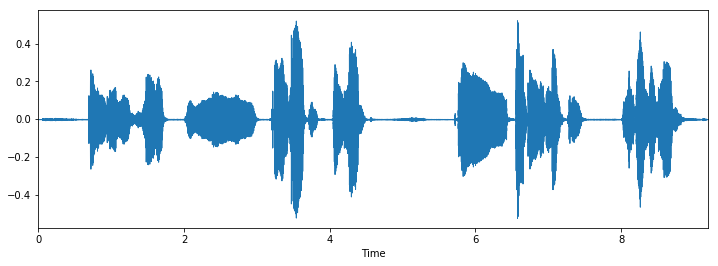

In [3]:
print("Frequency:",fs)
print("Duration:",len(wave)/fs,"s")

plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)

In [4]:
ipd.Audio(wave, rate=fs)

### 0. Trim the leading silence portion

#### Source: https://musicinformationretrieval.com/energy.html

In [5]:
def strip(x, frame_length, hop_length):

    # Compute RMSE.
    rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length, center=True)
    
    # Identify the first frame index where RMSE exceeds a threshold.
    thresh = 0.01
    frame_index = 0
    while rmse[0][frame_index] < thresh:
        frame_index += 1
        
    # Convert units of frames to samples.
    start_sample_index = librosa.frames_to_samples(frame_index, hop_length=hop_length)
    
    # Return the trimmed signal.
    return x[start_sample_index:]

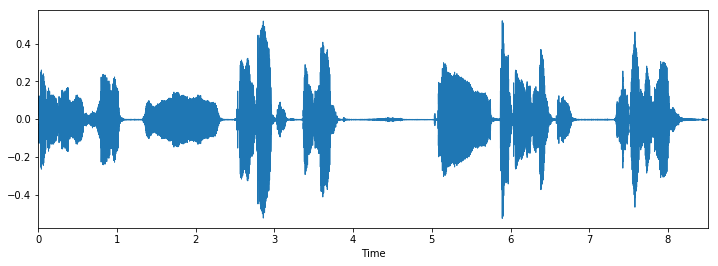

In [6]:
wave = strip(wave, 20, 10) #Trim with 20ms frame length and 10ms hop length
plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)

### End-point detection (VAD) 

#### Detecting the start point and end point of voice activity

#### Source: https://www.kaggle.com/jerrypeng/dsp-tutorial-3-demos-for-speech-processing

### 1. Calculate RMS and Zero Crossing Rate

In [7]:
frame_len = int(40 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
# calculate RMS
rms = librosa.feature.rmse(wave, frame_length=frame_len, hop_length=frame_shift)
rms = rms[0]
rms = librosa.util.normalize(rms, axis=0)

# calculate zero-crossing rate
zrc = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift, threshold=0)
zrc = zrc[0]
#zrc = librosa.util.normalize(zrc, axis=0)

### 2. Visualize the amplitude with RMS Energy and Zero Crossing Rate

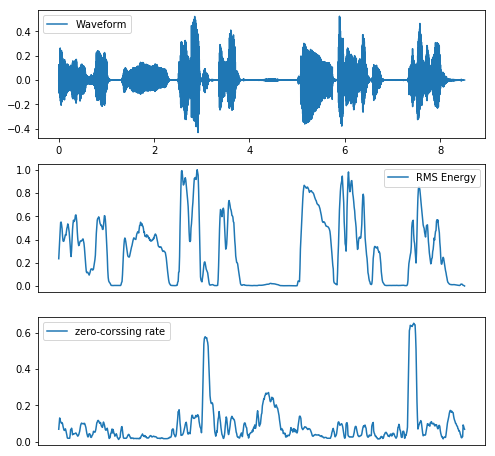

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(rms.T, label='RMS Energy')
plt.xticks([])
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(zrc.T, label='zero-corssing rate')
plt.xticks([])
plt.legend(loc='best')
plt.show()

### 3. Set threshold of speech and silence

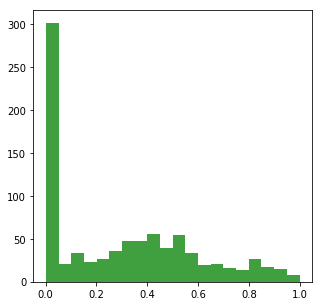

In [9]:
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(rms.T, 20, facecolor='g', alpha=0.75)

Based on the histogram above, we can set threshold of RMS at 0.1 and 0.5 for zrc.

In [10]:
frame_idxs = np.where( (rms > 0.1) | (zrc > 0.5) )[0]

### 4. Based on the frame indices, get start and end points of frames

In [11]:
def getboundaries(frame_idxs):
    #get the first frame index
    start_idxs = [frame_idxs[0]]
    end_idxs = []

    #get the length of list of frame indices
    shapeofidxs = np.shape(frame_idxs)

    #for each index in the list 
    for i in range(shapeofidxs[0]-1):
        #if the next index is in a different frame (difference > 1)
        if (frame_idxs[i + 1] - frame_idxs[i]) != 1:
            #i is an end index 
            end_idxs.append(frame_idxs[i])
            #i+1 is a start index
            start_idxs.append(frame_idxs[i+1])
            
    #last index of the list will be an end index
    end_idxs.append(frame_idxs[-1])
    
    # del the last boundaries if it is both start point and end point.
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), 'Error! Num of start_idxs doesnt match Num of end_idxs.'
    
    #convert into np.array
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    
    #from index, convert to time 
    start_t = start_idxs * frame_shift / fs
    end_t = end_idxs * frame_shift / fs
    return start_t, end_t

In [12]:
start_t, end_t = getboundaries(frame_idxs)
print("Number of frames: ", len(start_t))

Number of frames:  10


### 5. Visualize the wave with frames (Red: start, Green: end)

Problem: The start and end time periods yielded out from getBoundaries do not match with the time domain so that we can iterate through wave file and save all the points of a frame 

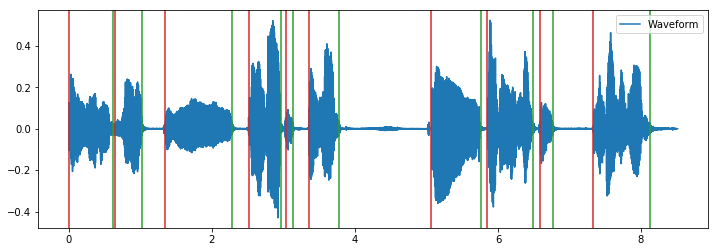

In [13]:
plt.figure(figsize=(12, 4))
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
for s, e in zip(start_t, end_t):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()

### 6. Reformate the time frame limits computed by the algorithms (to be consistence with the wave's time domain)

In [14]:
#Reformat the time frame limits computed by the algorithms 

#Cut down to 10 decimal place, used to be 16
start_t = [(float("{0:.10f}".format(x))) for x in start_t]
end_t = [(float("{0:.10f}".format(i))) for i in end_t]

#Compare with the real timeline of the file, take the time period nearest to 4 decimal place 
s = 0
e = 0
#Retrieve the time frame correspond to the real time graph
new_start = []
new_end = []
time = np.linspace(0, len(wave)/fs, len(wave))
time = [(float("{0:.10f}".format(a))) for a in time]
for t in time: 
    if s < len(start_t) and abs(start_t[s]-t) < 0.0001:
#         print("start","algo: ", start_t[s],"    " ,"original from graph: ", t)
        new_start.append(t)
        s = s + 1
    elif e < len(end_t) and abs(end_t[e]-t) < 0.0001:
#         print(" end","algo: ", end_t[e], "    ","original from graph: ", t)
        new_end.append(t)
        e = e + 1

### 7. Redraw the graph

Just to make sure there's no huge discrepency


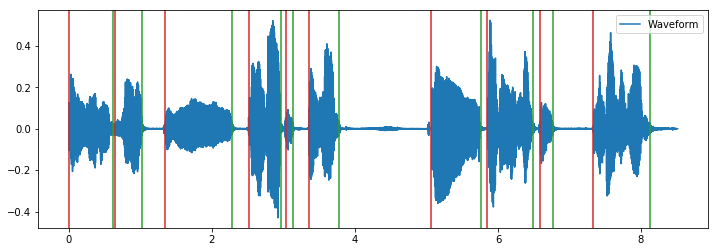

In [15]:
#Redraw the graph
plt.figure(figsize=(12, 4))
time = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(time, wave, label='Waveform')
for s, e in zip(new_start, new_end):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()

### 8. Cut the original wave file into chunks corresponding the computed frame 

In [16]:
#Cut the original wave file into chunks corresponding the computed frame 
chunks = []
frame = []
inFrame = False
frame_idx = 0
num_frames = len(new_start)
time = np.linspace(0, len(wave)/fs, len(wave))
time = [(float("{0:.10f}".format(a))) for a in time]
for w,t in zip(wave,time):
    #if t is the beginning of a frame
    if t == new_start[frame_idx]:
#         print("Start Frame!",t)
        #raise the inFrame flag, start collecting the wave
        inFrame = True
    #if t is the end of a frame
    elif t == new_end[frame_idx]:
#         print("End Frame!",t)
        #collect the last value
        frame.append(w)
        #add the frame to the chunks
        chunks.append(frame)
        #reset the frame 
        frame = []
        #increment the frame index 
        frame_idx += 1
        #unflag the inFrame flag, stop collecting the wave
        inFrame = False
    #if t is somewhere in the frame, collect it
    if inFrame == True: 
        frame.append(w)
    #if no frame left to search for, break
    if frame_idx == num_frames:
        break
len(chunks)

10

### 8.5 If chunks has less than 1500 points, consider inaudible sound -> delete

In [17]:
chunks = [chunk for chunk in chunks if len(chunk) > 1500]

### 9. CHECK some of the first CHUNKS 

In [18]:
#Mama's always
# print("Num points:",len(chunks[0]))
# ipd.Audio(chunks[0], rate=fs)

In [19]:
#Uhh
# print("Num points:",len(chunks[1]))
# ipd.Audio(chunks[1], rate=fs)

In [20]:
#Said life
# print("Num points:",len(chunks[2]))
# ipd.Audio(chunks[2], rate=fs)

In [21]:
#is a
# print("Num points:",len(chunks[3]))
# ipd.Audio(chunks[3], rate=fs)

In [22]:
#uhh
# print("Num points:",len(chunks[4]))
# ipd.Audio(chunks[4], rate=fs)

In [23]:
#box
# print("Num points:",len(chunks[5]))
# ipd.Audio(chunks[5], rate=fs)

In [24]:
# #Unknown
# print("Num points:",len(chunks[6]))

# ipd.Audio(chunks[6], rate=fs)

In [25]:
#Cho
# print("Num points:",len(chunks[7]))
# ipd.Audio(chunks[7], rate=fs)

In [26]:
# #You never know what you're
# print("Num points:",len(chunks[8]))

# ipd.Audio(chunks[8], rate=fs)

In [27]:
#Uhh
# print("Num points:",len(chunks[9]))
# ipd.Audio(chunks[9], rate=fs)

In [28]:
# #Gonna
# print("Num points:",len(chunks[10]))
# ipd.Audio(chunks[10], rate=fs)

In [29]:
#Get
# print("Num points:",len(chunks[11]))
# ipd.Audio(chunks[11], rate=fs)

# Part 2
## For each chunk created, performe PCA, save the updated version into a df

### 1. Perform PCA with given number of components
#### Assuming that each point of the wave file is a feature 

In [31]:
from sklearn.decomposition import PCA
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import numpy as np

### 1.1 Plot the CVE of each chunk to determine a good number of components 

#### 4 is chosen

In [32]:
import sklearn
def plot_CVE(wave):
    X = librosa.feature.mfcc(wave, sr=fs)
    X = sklearn.preprocessing.scale(X)  
    pca = PCA().fit(X)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

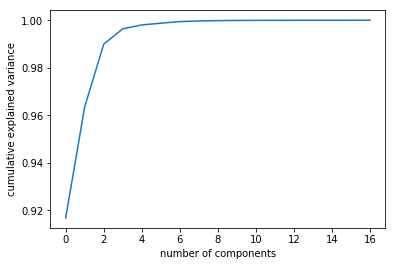

In [33]:
chunk1, fs1 = librosa.load("chunk1.wav")
plot_CVE(chunk1)

### 1.2 Compute some features using MFCC and scale the features to have zero mean and unit variance:

#### Suggested by: https://musicinformationretrieval.com/pca.html


In [45]:
#Return a uniformed matrix of data points with 4 columns 
def gen_PCA(wave,num_components,fs):
    #Compute some features
    X = librosa.feature.mfcc(wave, sr=fs)
    #Scale the feature to have zero mean
    X = sklearn.preprocessing.scale(X)    
    #print ("Old Shape",X.shape)
    #print("Mean",X.mean())
    model = sklearn.decomposition.PCA(n_components=num_components, svd_solver='auto')
    Y = model.fit_transform(X)
    #print ("New Shape",Y.shape)
    #print ("Component shape",model.components_.shape)
    return Y

### 1.3 Plot the two top principal components for each data point


In [46]:
#Plot the two top principal components for each data point:
def plot_top2(matrix):
    plt.rcParams['figure.figsize'] = (14, 5)
    plt.scatter(matrix[:,0], matrix[:,1],)

In [47]:
import pandas as pd
import sklearn
from pydub import AudioSegment
from pydub.silence import split_on_silence
from pydub.playback import play
import librosa
import os

# splits given sound file into chunks and saves to the
# splitAudio file as numbered chunk .wav files.
COMPONENT_NUMBER = 4
def splitIntoChunk(path):
    
    filenames = path.split("/")
    orgFilename = filenames[0] #filler
    #wavFilename = filenames[1] #filler.wav
    
    '''If you have the pydub module installed & working, this code produces nearly identical .wav
         files and saves them to a folder.
         sound_file = AudioSegment.from_wav(path)
         audio_chunks = split_on_silence(sound_file,min_silence_len=20,silence_thresh = -40)
    '''

    for i, chunk in enumerate(chunks):
        out_file = "chunk{0}.wav".format(i)
        librosa.output.write_wav(out_file,np.array(chunk),fs)
        #chunk.export(out_file, format="wav") #uncomment when using pydub
    filler = 0
    if "filler" in orgFilename:
        filler = 1
    return dfFormat(orgFilename, filler)
        
# Extracts audio chunks from the splitAudio folder and passes them into the chunkInfo method    
def dfFormat(orgFilename, filler):
    result = []
    for chunk in os.listdir("."):
        if "_" not in chunk and "chunk" in chunk:
            wav, fs = librosa.load(chunk)
            data = chunkInfo(chunk[5:7], orgFilename, filler, wav)
            result.append(data)
    return result        
            

# return an array as such: [orgin filename, chunk number, PCA matrix, isFiller] to create a df  
def chunkInfo(chunkNum, orgFilename, filler,wav):
    #result = [orgFilename, int(chunkNum.replace(".","")), wav, 0]
    result = [orgFilename, int(chunkNum.replace(".","")), gen_PCA(wav, COMPONENT_NUMBER, fs), 0] # 0 for now
    #result.append(int(chunkNum.replace(".","")))
   # result.append(filler)
    return result

### 2. Writing chunks of points into .wav file 

In [48]:
#PCA, feature extraction, try with large PCS ( like 200)
# for i, chunk in enumerate(chunks):
#     out_file = foldername+"chunk{0}.wav".format(i)
#     librosa.output.write_wav(out_file, np.array(chunk), fs)

### 3. Create a DataFrame with different chunks, feautred wave and isFiller column - creating the test data

In [49]:
df = pd.DataFrame(splitIntoChunk(filename+".wav"), columns=["Original File","Chunk Number","Featured Wave","is Filler"])

In [50]:
df

,Original File,Chunk Number,Featured Wave,is Filler
0,greeneggs_filler.wav,0,"[[18.93512702067224, -1.502269658371494, 0.376...",0
1,greeneggs_filler.wav,1,"[[15.073268793990191, -1.3419783425080127, -0....",0
2,greeneggs_filler.wav,2,"[[24.926328325904638, -0.5804382959042317, -0....",0
3,greeneggs_filler.wav,3,"[[13.48031454157676, -2.7138189381818636, 0.39...",0
4,greeneggs_filler.wav,4,"[[9.112718892629061, 0.01543894303247718, -0.0...",0
5,greeneggs_filler.wav,5,"[[14.248361379801835, -1.9835065624045414, 0.3...",0
6,greeneggs_filler.wav,6,"[[19.221717821774504, -1.1308973687419885, 0.1...",0
7,greeneggs_filler.wav,7,"[[17.701399618714685, -1.9198616670773085, -0....",0
8,greeneggs_filler.wav,8,"[[10.33215979188669, 0.680838360141088, 0.0673...",0
9,greeneggs_filler.wav,9,"[[19.298560459121276, 5.1786187303983136, 0.10...",0


### Before exporting into .csv, modify isFiller column accordingly!!!

In [51]:
#This is for the green egss filler only, make sure to modify the row numbers accordingly
df.loc[[2,6],'is Filler'] = 1

### Exporting into .csv file

In [52]:
df.to_csv(filename+'.csv', sep=',', index=False)

### Double check if the .csv has data you want

In [53]:
df2 = pd.read_csv(filename+'.csv')
df2

,Original File,Chunk Number,Featured Wave,is Filler
0,greeneggs_filler.wav,0,[[ 1.89351270e+01 -1.50226966e+00 3.76202153e...,0
1,greeneggs_filler.wav,1,[[15.07326879 -1.34197834 -0.17174313 -0.32071...,0
2,greeneggs_filler.wav,2,[[ 2.49263283e+01 -5.80438296e-01 -8.76971514e...,1
3,greeneggs_filler.wav,3,[[ 1.34803145e+01 -2.71381894e+00 3.93554691e...,0
4,greeneggs_filler.wav,4,[[ 9.11271889e+00 1.54389430e-02 -3.31799642e...,0
5,greeneggs_filler.wav,5,[[ 14.24836138 -1.98350656 0.30833468 -0.2...,0
6,greeneggs_filler.wav,6,[[ 1.92217178e+01 -1.13089737e+00 1.56231395e...,1
7,greeneggs_filler.wav,7,[[ 1.77013996e+01 -1.91986167e+00 -2.45668009e...,0
8,greeneggs_filler.wav,8,[[ 1.03321598e+01 6.80838360e-01 6.73303430e...,0
9,greeneggs_filler.wav,9,[[ 1.92985605e+01 5.17861873e+00 1.04723572e...,0
